In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Convert timestamps to seconds
def timestamp_to_seconds(timestamp):
    h, m, s = timestamp.split(':')
    return int(h) * 3600 + int(m) * 60 + float(s)

In [3]:
tvsum50_video = "/kaggle/input/tvsum50/tvsum50/video"
tvsum50_anno = "/kaggle/input/tvsum50/tvsum50/data/ydata-tvsum50-anno.tsv"
tvsum50_info = "/kaggle/input/tvsum50/tvsum50/data/ydata-tvsum50-info.tsv"

experiment_results = "/kaggle/input/experiment-2"
# experiment_tag = "_m1w-1.0_m2w-0.3_mdt-0.2_keep"
experiment_tag = "_m1w-1.0_m2w-0.3_mdt-0.2_sentences"

In [4]:
# ['category', 'video_id', 'title', 'url', 'length']
info_df = pd.read_csv(tvsum50_info,sep='\t')

# 0: video_id, 1: category, 2: scores <string of csv scores>
anno_df = pd.read_csv(tvsum50_anno, delimiter='\t', header=None)
anno_df.columns = ['video_id', 'category', 'scores']

# scores array <int array>
anno_df["scores"] = anno_df["scores"].apply(lambda x: np.fromstring(x, sep=',', dtype=int))

In [5]:
# ['metric_final', 'start_time', 'end_time', 'base_idx', 'sentence']
def get_experiment_df(name):
    return pd.read_csv(os.path.join(experiment_results, name) + experiment_tag +".csv")

In [6]:
def get_video_info(name):
    # Load the video
    video = cv2.VideoCapture(f'/kaggle/input/tvsum50/tvsum50/video/{name}.mp4')
    
    # Get the frames per second (FPS)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Get the total number of frames in the video
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the video length in seconds
    video_length_sec = frame_count / fps
    
    return (video_length_sec,frame_count,fps)

In [7]:
def plot_experiment_results(video_title, frame_scores, title_prefix="", print_title=False):
    filtered_df = info_df[info_df["video_id"] == video_title]
    if filtered_df.empty:
        raise ValueError(f"Video ID {video_title} not found in info_df")

    title = filtered_df["title"].iloc[0]
    length = filtered_df["length"].iloc[0]
    category = filtered_df["category"].iloc[0]

    plt.close('all')  # Prevent multiple plots
    plt.figure(figsize=(10,5))  # Set figure size before plotting
    plt.plot(frame_scores, label='Average Value')

    plt.xlabel('Frame Index')
    plt.ylabel('Average')
    
    plot_title = f'{title_prefix} Score Plot for "{title}" [{video_title}] - [{category}] - {length}s'
    plt.title(plot_title)
    
    if print_title:
        print(plot_title)

    plt.legend()
    plt.show()


# Experiment Exploration

The 50 videos are grouped by 10 categories (5 videos per category).
The categories are identified by two-letter codes, whose names are:

#### Categories:
- **VT**: Changing Vehicle Tire  
- **VU**: Getting Vehicle Unstuck  
- **GA**: Grooming an Animal  
- **MS**: Making Sandwich  
- **PK**: Parkour  
- **PR**: Parade  
- **FM**: Flash Mob Gathering  
- **BK**: Bee Keeping  
- **BT**: Attempting Bike Tricks  
- **DS**: Dog Show  

In [8]:
videos_of_interest = [
    "0tmA_C6XwfM", #GA
    "98MoyGZKHXc", #VT
    "akI8YFjEmUw", # ?
    "AwmHb44_ouw", # VT
    "Bhxk-O1Y7Ho", # GA
    "EE-bNr36nyA", # BK
    "eQu1rNs0an0", # BT
    "gzDbaEs1Rlg", # VT
    "Hl-__g2gn_A", # MS
    "jcoYJXDG9sw", # DS
    "JgHubY5Vw3Y", # ?
    "RBCABdttQmI", # PR
    "Se3oxnaPsz0", # BK
    "sTEELN-vY30", # VU ?
    "xwqBXPGE9pQ",
    "xxdtq8mxegs",
    "XzYM3PfTM4w",
    "Yi4Ij2NM7U4"
]

videos_of_interest_df = info_df[info_df["video_id"].isin(videos_of_interest)]

videos_of_interest_df.to_csv(f'/kaggle/working/videos_of_interest.csv', index=False)

display(videos_of_interest_df)

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51
6,VU,sTEELN-vY30,BBC - Train crash 2013,https://www.youtube.com/watch?v=sTEELN-vY30,2:29
8,VU,xwqBXPGE9pQ,Smart Electric Vehicle Balances on Two Wheels,https://www.youtube.com/watch?v=xwqBXPGE9pQ,3:53
9,VU,akI8YFjEmUw,Electric cars making earth more green,https://www.youtube.com/watch?v=akI8YFjEmUw,2:13
11,GA,Bhxk-O1Y7Ho,Vlog #509 I'M A PUPPY DOG GROOMER! September 1...,https://www.youtube.com/watch?v=Bhxk-O1Y7Ho,7:30
12,GA,0tmA_C6XwfM,Nail clipper Gloria Pets professional grooming,https://www.youtube.com/watch?v=0tmA_C6XwfM,2:21
14,GA,xxdtq8mxegs,How to Clean Your Dog's Ears - Vetoquinol USA,https://www.youtube.com/watch?v=xxdtq8mxegs,2:24


## MMVTrim Experiemnt Results: Will a Cat Eat Dog Food ? [-esJrBWj2d8]

In [9]:
video_title = "-esJrBWj2d8"
experiment_df = get_experiment_df(video_title)

In [10]:
experiment_df.head()

,metric_final,start_time,end_time,base_idx,sentence
0,0.35,00:00:01.316,00:00:01.717,0,Him every.
1,0.40,00:00:02.998,00:00:03.778,1,Do you know what this is?
2,0.55,00:00:05.841,00:00:07.059,2,Do you want some cat food?
3,0.33,00:00:07.081,00:00:13.205,3,No.
4,0.24,00:00:14.067,00:00:14.787,4,What else do we have?


In [11]:
# Timestamp to Frame conversion

# Preprocessing
experiment_df['start_seconds'] = experiment_df['start_time'].apply(timestamp_to_seconds)
experiment_df['end_seconds'] = experiment_df['end_time'].apply(timestamp_to_seconds)

# Linear Scaling: from 0-1 to 1-5
experiment_df['scaled_metric_final'] = experiment_df['metric_final'] * 4 + 1

experiment_df.head()

,metric_final,start_time,end_time,base_idx,sentence,start_seconds,end_seconds,scaled_metric_final
0,0.35,00:00:01.316,00:00:01.717,0,Him every.,1.316,1.717,2.40
1,0.40,00:00:02.998,00:00:03.778,1,Do you know what this is?,2.998,3.778,2.60
2,0.55,00:00:05.841,00:00:07.059,2,Do you want some cat food?,5.841,7.059,3.20
3,0.33,00:00:07.081,00:00:13.205,3,No.,7.081,13.205,2.32
4,0.24,00:00:14.067,00:00:14.787,4,What else do we have?,14.067,14.787,1.96


In [12]:
# Map socres to frames
(length_s,n_frames, fps) = get_video_info(video_title)

if fps != 30.0:
    print(f"===== WARN: VIDEO {video_title} is not 30FPS. Was {fps}")

# Initialize array with 1's (lowest score)
frame_scores = np.ones(n_frames)

# Assign scores to frames
for index, row in experiment_df.iterrows():
    start_frame = int(row['start_seconds'] * fps)
    end_frame = int(row['end_seconds'] * fps)
    frame_scores[start_frame:end_frame] = row['scaled_metric_final']

print(frame_scores, '\n')

[1. 1. 1. ... 1. 1. 1.] 



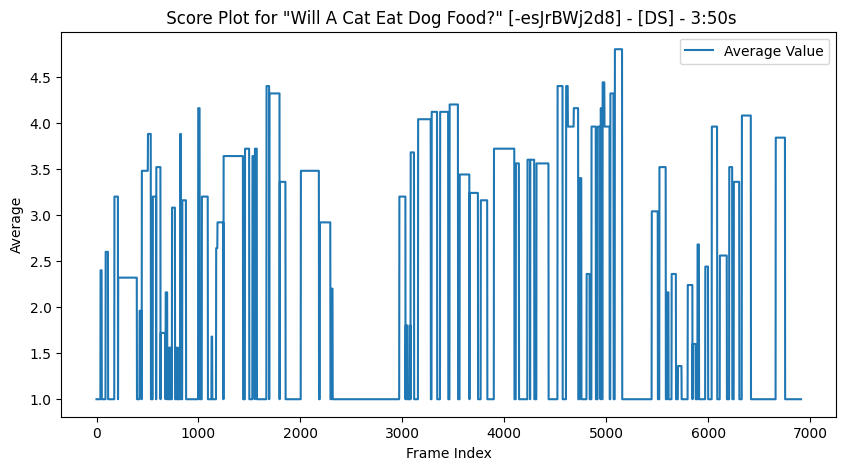

In [13]:
# Plot
plot_experiment_results(video_title, frame_scores)

## Re-run Original Exmple: Will A Cat Eat Dog Food (-esJrBWj2d8)
##### Re-running Experiment to Confirm Consistency

In [14]:
video_title = "-esJrBWj2d8"
i_df = info_df[info_df["video_id"] == video_title]
a_df = anno_df[anno_df["video_id"] == video_title]

display(i_df)
display(a_df.head())

# frame array length
print(f"frame length: {len(a_df.iloc[0]['scores'])}")
print(f"6912/30fps = {6912/30} seconds\n")

# stack values in column into single matrix
scores_matrix = np.stack(a_df["scores"].values) 

# Calculate the average of each index across all rows
cat_food_scores = np.mean(scores_matrix, axis=0)

# Display the averaged scores
print(cat_food_scores)

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


,video_id,category,scores
980,-esJrBWj2d8,DS,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
981,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
982,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
983,-esJrBWj2d8,DS,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
984,-esJrBWj2d8,DS,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


frame length: 6912
6912/30fps = 230.4 seconds

[1.95 1.95 1.95 ... 1.5  1.5  1.5 ]


In [15]:
(length_s,n_frames, fps) = get_video_info(video_title)

print(f"FPS: {fps}")
print(f"Video Length: {length_s} seconds")
print(f"Num Frames: {n_frames}")

FPS: 30.0
Video Length: 230.4 seconds
Num Frames: 6912


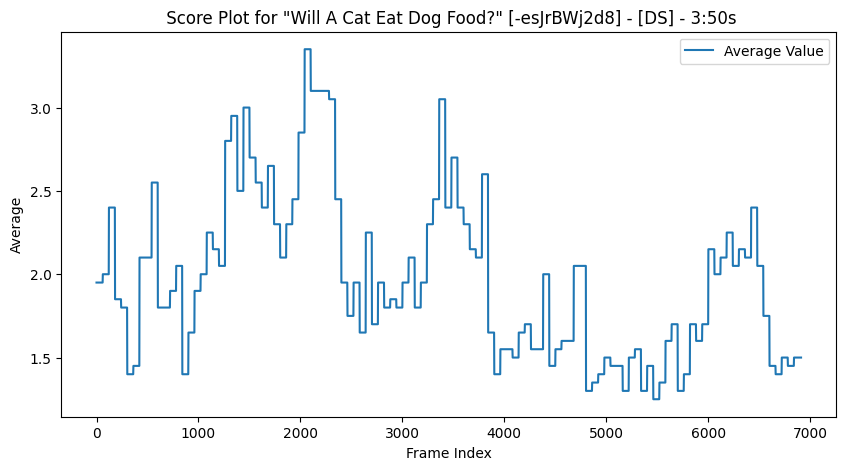

In [16]:
# Plot
plot_experiment_results(video_title, cat_food_scores)

## Question: Scene Consistency: Shouldn't each 60 frame segment share the same score across the 60 frames ?
##### If the experiment is rates 2 second scenes, we should see 2 seconds = 60 frames total having the same score when going frame by frame, for any of the 20 individual scores

In [17]:
n_frames=30

score_1 = a_df.iloc[0]['scores'][1:6901]

reshaped_scores = score_1.reshape(-1, n_frames)
consistent = np.all(reshaped_scores == reshaped_scores[:, 0][:, None], axis=1)
print("All n-frame segments have the same score:", np.all(consistent),'\n')

reshaped_df = pd.DataFrame(reshaped_scores, columns=[f"{i+1}" for i in range(n_frames)])

display(reshaped_df)

All n-frame segments have the same score: True 



,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
226,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
227,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
228,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Index Chosen for consistency: [1:6901] from [0:6912]
#### These are the values leftover:

In [18]:
# Leftover ratings
print(a_df.iloc[0]['scores'][0:1], a_df.iloc[0]['scores'][6901:])

[1] [1 1 1 1 1 1 1 1 1 1 1]


# Multi-Experiment Run

In [19]:
def calc_tvsum_score(video_id):
    return np.mean(
        np.stack(anno_df.loc[anno_df["video_id"] == video_id, "scores"]),
        axis=0
    )

In [20]:
def calc_mmvtrim_score(video_id, fps_warn=False):
    experiment_df = get_experiment_df(video_id)

    # Preprocessing
    experiment_df['start_seconds'] = experiment_df['start_time'].apply(timestamp_to_seconds)
    experiment_df['end_seconds'] = experiment_df['end_time'].apply(timestamp_to_seconds)
    
    # Linear Scaling: from 0-1 to 1-5
    experiment_df['scaled_metric_final'] = experiment_df['metric_final'] * 4 + 1
    
    # Map socres to frames
    (length_s,n_frames, fps) = get_video_info(video_id)
    if fps_warn and fps != 30.0:
        print(f"===== WARN: VIDEO {video_id} is not 30 fps. Was {fps:.4g} fps. Rounding to {round(fps)} fps.")
        fps = round(fps)
    
    # Initialize array with ones
    frame_scores = np.ones(n_frames)
    
    # Assign scores to frames
    for index, row in experiment_df.iterrows():
        start_frame = int(row['start_seconds'] * fps)
        end_frame = int(row['end_seconds'] * fps)
        frame_scores[start_frame:end_frame] = row['scaled_metric_final']
    
    return frame_scores

In [21]:
def evaluate_trim(threshold_percent, ground_truth_array, eval_array, print_scores=False):    
    
    # Handle case when threshold_percent is 0
    if threshold_percent == 0:
        ground_truth_threshold = np.min(ground_truth_array)
        eval_threshold = np.min(eval_array)
    else:
        # Calculate the threshold dynamically based on the percentage to delete
        ground_truth_threshold = np.percentile(ground_truth_array, threshold_percent * 100)
        eval_threshold = np.percentile(eval_array, threshold_percent * 100)
    
    # Apply the threshold
    ground_truth_binary = np.where(ground_truth_array >= ground_truth_threshold, 1, 0)
    eval_binary = np.where(eval_array >= eval_threshold, 1, 0)

    # Ensure ground_truth_binary is shorter or equal in length
    if len(ground_truth_binary) != len(eval_binary):
        eval_binary = eval_binary[:-1]  # Remove last element from eval_binary if it's longer
    
    # Cosine Similarity
    cosine_sim = cosine_similarity([ground_truth_binary], [eval_binary])[0][0]

    # # Cosine Similarity
    # cosine_sim = cosine_similarity([ground_truth_binary], [eval_binary])[0][0]
    
    # Confusion Matrix and Metrics
    cm = confusion_matrix(ground_truth_binary, eval_binary)
    if cm.size == 4:  # Ensure the confusion matrix has 4 values (TN, FP, FN, TP)
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0  # Handle the case where the confusion matrix is not full
    
    accuracy = accuracy_score(ground_truth_binary, eval_binary)
    precision = precision_score(ground_truth_binary, eval_binary)
    recall = recall_score(ground_truth_binary, eval_binary)
    f1 = f1_score(ground_truth_binary, eval_binary)

    # Return all metrics as a dictionary
    metrics = {
        "trim": threshold_percent,
        "cosine_similarity": cosine_sim,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": {
            "true_negative": tn,
            "false_positive": fp,
            "false_negative": fn,
            "true_positive": tp
        }
    }

    if print_scores:
        print("Trim %:", threshold_percent, '\n')
        print("Cosine Similarity:", cosine_sim, '\n')
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall, '\n')
        print("F1-Score:", f1)

    return metrics

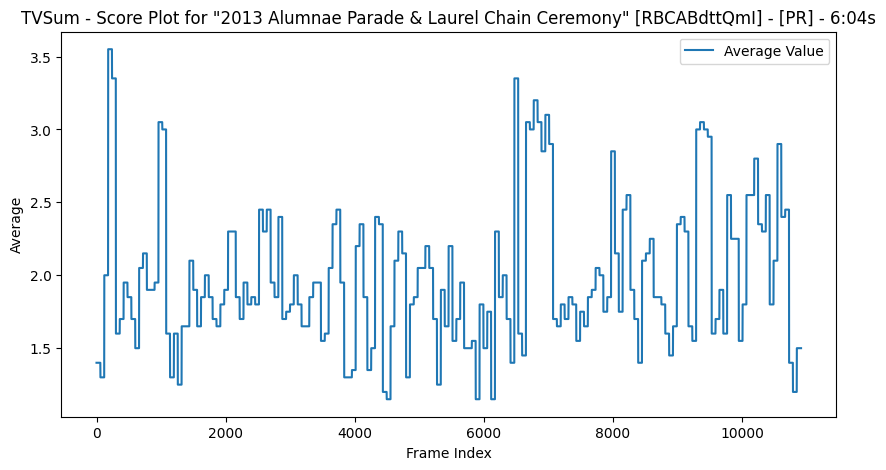

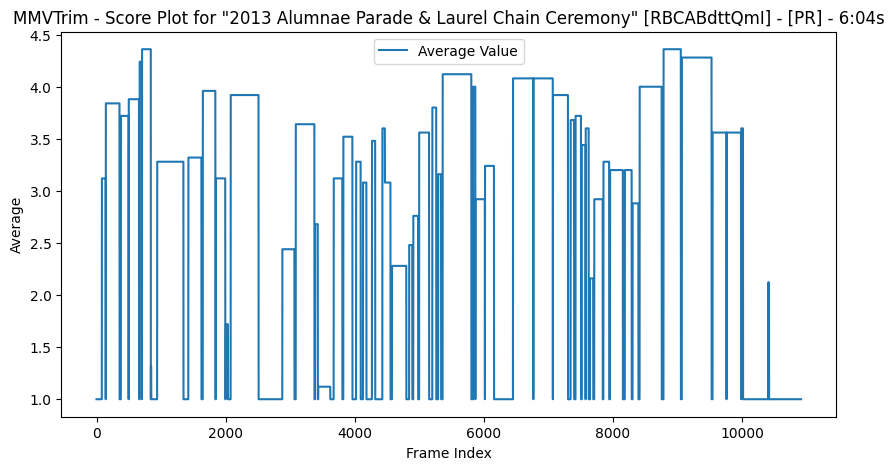

In [22]:
video_id = "RBCABdttQmI"

# TVSum Scores
tvsum_scores = calc_tvsum_score(video_id)

# MMVTrim Scores
mmvtrim_scores = calc_mmvtrim_score(video_id)

plot_experiment_results(video_id, tvsum_scores, title_prefix="TVSum -", print_title=False)
plot_experiment_results(video_id, mmvtrim_scores, title_prefix="MMVTrim -")

## F1-Score Evaluation

In [23]:
threshold_percent = 0.3
# ground_truth_array = np.array([1, 2, 3, 3, 4, 1, 5, 2, 4, 3])
# eval_array = np.array([1, 2, 3, 2, 4, 2, 5, 1, 4, 3])
ground_truth_array = tvsum_scores
eval_array = mmvtrim_scores

print_scores = True

# Handle case when threshold_percent is 0
if threshold_percent == 0:
    ground_truth_threshold = np.min(ground_truth_array)
    eval_threshold = np.min(eval_array)
else:
    # Calculate the threshold dynamically based on the percentage to delete
    ground_truth_threshold = np.percentile(ground_truth_array, threshold_percent * 100)
    eval_threshold = np.percentile(eval_array, threshold_percent * 100)

# Apply the threshold
ground_truth_binary = np.where(ground_truth_array >= ground_truth_threshold, 1, 0)
eval_binary = np.where(eval_array >= eval_threshold, 1, 0)


print("ground truth original", ground_truth_array)
print("ground truth binary: ", ground_truth_binary)
print("ground truth threshold: ", ground_truth_threshold)

print("\neval array original: ", eval_array)
print("eval array binary:   ", eval_binary)
print("eval array threshold: ", eval_threshold)

# Cosine Similarity
cosine_sim = cosine_similarity([ground_truth_binary], [eval_binary])[0][0]

# Confusion Matrix and Metrics
cm = confusion_matrix(ground_truth_binary, eval_binary)
if cm.size == 4:  # Ensure the confusion matrix has 4 values (TN, FP, FN, TP)
    tn, fp, fn, tp = cm.ravel()
else:
    tn = fp = fn = tp = 0  # Handle the case where the confusion matrix is not full

accuracy = accuracy_score(ground_truth_binary, eval_binary)
precision = precision_score(ground_truth_binary, eval_binary)
recall = recall_score(ground_truth_binary, eval_binary)
f1 = f1_score(ground_truth_binary, eval_binary)

# Return all metrics as a dictionary
metrics = {
    "trim": threshold_percent,
    "cosine_similarity": cosine_sim,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "confusion_matrix": {
        "true_negative": tn,
        "false_positive": fp,
        "false_negative": fn,
        "true_positive": tp
    }
}

if print_scores:
    print("\nTrim %:", threshold_percent, '\n')
    print("Cosine Similarity:", cosine_sim, '\n')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall, '\n')
    print("F1-Score:", f1)

ground truth original [1.4 1.4 1.4 ... 1.5 1.5 1.5]
ground truth binary:  [0 0 0 ... 0 0 0]
ground truth threshold:  1.7

eval array original:  [1. 1. 1. ... 1. 1. 1.]
eval array binary:    [0 0 0 ... 0 0 0]
eval array threshold:  2.2800000000000002

Trim %: 0.3 

Cosine Similarity: 0.7041578453360554 

Accuracy: 0.5768984153155629
Precision: 0.7029411764705882
Recall: 0.7053766200436289 

F1-Score: 0.7041567924165759


## F1 Graph at all Thresholds

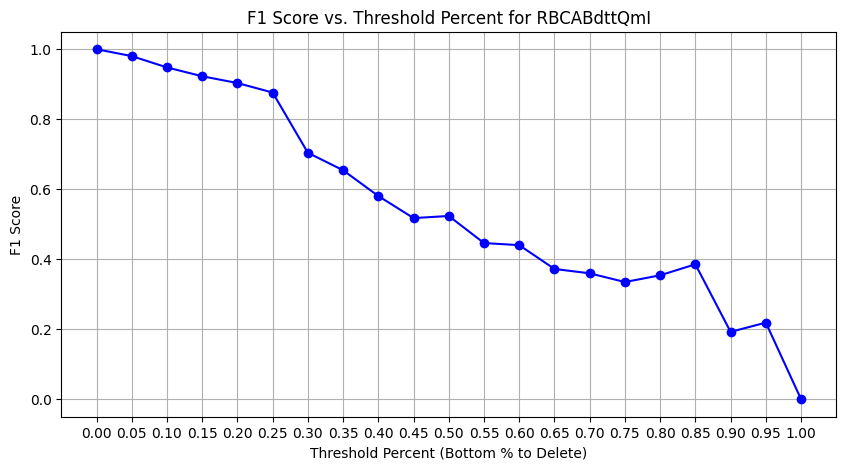

In [24]:
# tvsum_scores = np.array([1, 2, 3, 3, 4, 1, 5, 2, 4, 3])
# mmvtrim_scores = np.array([1, 2, 3, 2, 4, 2, 5, 1, 4, 3])

# range of threshold_percent values
threshold_percent_values = np.arange(0, 1.05, 0.05)  # From 0.05 to 0.5 in steps of 0.05

# Initialize a list to store F1 scores
f1_scores = []

# Loop through each threshold_percent value
for threshold_percent in threshold_percent_values:
    # Evaluate the function
    trim_eval = evaluate_trim(threshold_percent, tvsum_scores, mmvtrim_scores, print_scores=False)
    
    # Append the F1 score to the list
    f1_scores.append(trim_eval["f1_score"])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(threshold_percent_values, f1_scores, marker='o', linestyle='-', color='b')
plt.title(f'F1 Score vs. Threshold Percent for {video_id}')
# plt.title(f'F1 a:{tvsum_scores}, b:{mmvtrim_scores}')
plt.xlabel("Threshold Percent (Bottom % to Delete)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.xticks(threshold_percent_values)
plt.show()

# All Experiments

In [25]:
# Experiments Df
f1_columns = np.round(np.arange(0, 1.05, 0.05), 2).tolist()
columns = [
    "video_id", 
    "title", 
    "category", 
    "url",
    "length",
    "video_of_interest"
] + f1_columns
experiments_all_df = pd.DataFrame(columns=columns)

for _, experiment in info_df.iterrows():
    experiment_data = {
        "video_id": experiment["video_id"],
        "title": experiment["title"],
        "category": experiment["category"],
        "url": experiment["url"],
        "length": experiment["length"],
        "video_of_interest": experiment["video_id"] in videos_of_interest
    }
    
    # Scores for TVSum/MMVtrim
    tvsum_scores = calc_tvsum_score(experiment["video_id"])
    mmvtrim_scores = calc_mmvtrim_score(experiment["video_id"])

    # F1 Columns Init
    for trim_threshold_percent in f1_columns:
        experiment_data[trim_threshold_percent] = None
            
    for trim_threshold_percent in f1_columns:
        scores = evaluate_trim(trim_threshold_percent, tvsum_scores, mmvtrim_scores)
        experiment_data[trim_threshold_percent] = scores["f1_score"]

    experiments_all_df.loc[len(experiments_all_df)] = experiment_data

experiments_all_df.head()

,video_id,title,category,url,length,video_of_interest,0.0,0.05,0.1,0.15,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,VT,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,True,1.0,0.979782,0.958730,0.930406,...,0.337783,0.312156,0.209178,0.142967,0.130463,0.054091,0.073869,0.079734,0.000000,0.0
1,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,VT,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,True,1.0,0.985172,0.951113,0.933212,...,0.533961,0.429011,0.323469,0.240753,0.214431,0.119375,0.000000,0.000000,0.000000,0.0
2,J0nA4VgnoCo,#0001: FLAT TIRE,VT,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,False,1.0,0.987871,0.947838,0.947838,...,0.495699,0.473938,0.388756,0.276396,0.247154,0.223066,0.159171,0.125249,0.117448,0.0
3,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,VT,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,True,1.0,0.978754,0.978754,0.929473,...,0.358613,0.308982,0.307721,0.314130,0.210883,0.191122,0.044405,0.000000,0.000000,0.0
4,XzYM3PfTM4w,When to Replace Your Tires GMC,VT,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,True,1.0,1.000000,0.952786,0.922255,...,0.508443,0.356725,0.374952,0.399611,0.303502,0.200258,0.281562,0.253129,0.000000,0.0


### Download

In [26]:
# Download

df_to_print = experiments_all_df
filename = f'/kaggle/working/experiments_all.csv'

df_to_print.to_csv(filename, index=False)

# # Display the link for downloading
# import os
# from IPython.display import FileLink

# # Provide a downloadable link
# FileLink(filename)